<a href="https://colab.research.google.com/github/codes-by-pinewood/RL-assignment-2/blob/main/dqn_and_dqn_tn_er.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import requests
import numpy as np

In [2]:
class Replaybuffer:
    def __init__(self, n_state, n_action):
        self.n_state = n_state
        self.n_action = n_action
        self.size = 2000 # Memory pool size
        self.batchsize = 10

        # Allocate space for the memory quintuple
        self.s = np.empty(shape=(self.size, self.n_state), dtype=np.float32)
        self.a = np.random.randint(low=0, high=n_action, size=self.size, dtype=np.uint8)
        self.r = np.empty(self.size, dtype=np.float32)
        self.done = np.random.randint(low=0, high=2, size=self.size, dtype=np.uint8)
        self.s_ = np.empty(shape=(self.size, self.n_state), dtype=np.float32)

        self.t = 0
        self.tmax = 0  # Initialize tmax attribute ##Added later

    def add_memo(self, s, a, r, done, s_): # Implement functionality: 1. Add memory after interaction 2. Extract memory when sampling batch
    # Add memory to the memory pool at step t
        #print("s:", s.shape)  # Print the shape of s
        #print("Expected s shape:", (self.n_state,))
        self.s[self.t] = s
        self.a[self.t] = a
        self.r[self.t] = r
        self.done[self.t] = done
        self.s_[self.t] = s_
        self.t = self.t + 1 if self.t + 1 < self.size else 1 # When t reaches 2001, start adding from 1 again
        self.tmax = max(self.tmax, self.t +1)

    def sample(self):
    # Sampling logic: If the Buffer has more experiences than the batchsize, then sample; if less, take as many as there are
        '''if self.tmax > self.size:
            idxes = random.sample(range(0, self.tmax), self.size)
        else:
            idxes = random.sample(range(0, self.tmax))'''

        if self.tmax > self.batchsize:
           k = self.batchsize  # If the buffer sample size is greater than or equal to the batch size, use the batch size
        else:
           k = self.tmax  # Otherwise, use the actual sample size of the buffer

        idxes = random.sample(range(0, self.tmax), k)  # Sample using the determined k value

        batch_s = []
        batch_a = []
        batch_r = []
        batch_done = []
        batch_s_ = []

        for idx in idxes: # Draw 64 pieces of data
            batch_s.append(self.s[idx])
            batch_a.append(self.a[idx])
            batch_r.append(self.r[idx])
            batch_done.append(self.done[idx])
            batch_s_.append(self.s_[idx])

        # Convert numpy to torch tensor
        batch_s = torch.as_tensor(np.asarray(batch_s), dtype=torch.float32)
        batch_a = torch.as_tensor(np.asarray(batch_a), dtype=torch.int64).unsqueeze(-1) # Dimension expansion: from (2) to (2,1)
        batch_r = torch.as_tensor(np.asarray(batch_r), dtype=torch.float32).unsqueeze(-1)
        batch_done = torch.as_tensor(np.asarray(batch_done), dtype=torch.float32).unsqueeze(-1)
        batch_s_ = torch.as_tensor(np.asarray(batch_s_), dtype=torch.float32)

        return batch_s, batch_a, batch_r, batch_done, batch_s_

class Qnetwork(nn.Module):
      def __init__(self, n_input, n_output):
          super().__init__() # Inherit from Module parent class

          self.net = nn.Sequential(
              nn.Linear(in_features= n_input, out_features = 128),
              nn.ReLU(), #nn.Tanh(),
              nn.Linear(in_features= 128, out_features = n_output))

      def forward(self, x):
           return self.net(x) # Forward propagation

      def act(self, obs): # Facing s, find the maximum Q value (because the neural network outputs more than just the maximum Q value), output the corresponding action
          obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
          q_value = self(obs_tensor.unsqueeze(0)) # Convert to row vector
          max_q_idx = torch.argmax(input=q_value)
          action = max_q_idx.detach().item() # Action corresponding to the index of the maximum Q value
          return action

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
class AgentwoRBTN:
   def __init__(self, n_input, n_output, Gamma=0.97, learning_rate = 0.01):
            self.n_input = n_input
            self.n_output = n_output
            self.learning_rate = learning_rate
            self.Gamma = Gamma
            self.online_net = Qnetwork(self.n_input, self.n_output)
            #self.target_net = Qnetwork(self.n_input, self.n_output)
            self.optimizer = torch.optim.Adam(self.online_net.parameters(),lr=self.learning_rate)

class Agent:
   def __init__(self, n_input, n_output, Gamma=0.97, learning_rate = 0.01):
            self.n_input = n_input
            self.n_output = n_output
            self.learning_rate = learning_rate
            self.Gamma = Gamma
            self.memo = Replaybuffer(self.n_input, self.n_output)

            self.online_net = Qnetwork(self.n_input, self.n_output)
            self.target_net = Qnetwork(self.n_input, self.n_output)

            self.optimizer = torch.optim.Adam(self.online_net.parameters(),lr=self.learning_rate)

In [5]:
env = gym.make('CartPole-v1')
n_input = env.observation_space.shape[0]
n_output = env.action_space.n

epsilon_decay = 10000
epsilon_start = 1.0 #best value from tuning hyperparameters
epsilon_end = 0.1
target_update = 5
n_step = 500
n_episode = 1000
TARGET_UPDATE = 10
Gamma=0.97
learning_rate = 0.01

In [32]:
##DQN (with target network AND experience replay)
s = env.reset()
np.random.seed(42)
agent = Agent(n_input, n_output)
episode_array = []
rewards_array = []
TARGET_UPDATE = 10
Reward_list = np.empty(shape=n_episode)
n_episode = 1000

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end]) #插值


        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode_array.append(episode)
        rewards_array.append(reward)



Episode:0
Reward:nan
Episode:10
Reward:21.3
Episode:20
Reward:12.0
Episode:30
Reward:12.3
Episode:40
Reward:15.9
Episode:50
Reward:10.7
Episode:60
Reward:14.3
Episode:70
Reward:23.2
Episode:80
Reward:24.3
Episode:90
Reward:15.0
Episode:100
Reward:17.0
Episode:110
Reward:15.5
Episode:120
Reward:12.2
Episode:130
Reward:15.0
Episode:140
Reward:18.4
Episode:150
Reward:12.9
Episode:160
Reward:17.1
Episode:170
Reward:34.0
Episode:180
Reward:38.7
Episode:190
Reward:27.8
Episode:200
Reward:43.6
Episode:210
Reward:60.6
Episode:220
Reward:41.6
Episode:230
Reward:41.4
Episode:240
Reward:50.9
Episode:250
Reward:65.6
Episode:260
Reward:65.9
Episode:270
Reward:59.8
Episode:280
Reward:49.1
Episode:290
Reward:92.5
Episode:300
Reward:108.3
Episode:310
Reward:144.3
Episode:320
Reward:188.3
Episode:330
Reward:90.2
Episode:340
Reward:65.9
Episode:350
Reward:40.7
Episode:360
Reward:133.3
Episode:370
Reward:217.5
Episode:380
Reward:222.9
Episode:390
Reward:260.4
Episode:400
Reward:36.0
Episode:410
Reward:41

In [ ]:
#Network without either replay buffer or the target network
agent2 = AgentwoRBTN(n_input, n_output)
episode2_array = []
rewards2_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000

s = env.reset()
np.random.seed(42)
for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end])
        random_sample = random.random()
        if random_sample <= epsilon:
            a = env.action_space.sample()
        else:
            a = agent2.online_net.act(s)

        s_, r, done, _ = env.step(a)
        epi_reward += r

        # Learning process
        target_q_values = agent2.online_net(torch.tensor(s_).unsqueeze(0))
        target_q = r + agent2.Gamma * (1 - done) * target_q_values.max(dim=1)[0]

        pred_q_values = agent2.online_net(torch.tensor(s).unsqueeze(0))
        pred_q = pred_q_values[0][a]

        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent2.optimizer.zero_grad()
        loss.backward()
        agent2.optimizer.step()

        s = s_

        if done:
            s = env.reset()
            Reward_list[episode] = epi_reward
            break

    if episode % TARGET_UPDATE == 0:
        #agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode2_array.append(episode)
        rewards2_array.append(reward)

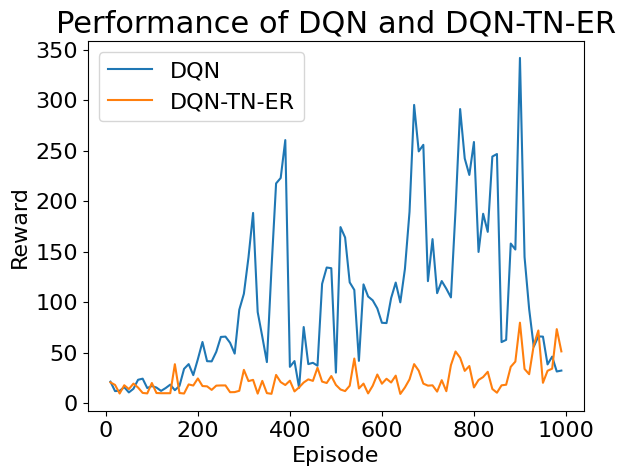

In [43]:
import matplotlib.pyplot as plt
import numpy as np

#set x and y for the final plot
x = episode_array
y = rewards_array
x2 = episode2_array
y2 = rewards2_array

plt.title("Performance of DQN and DQN-TN-ER",fontsize=22)
plt.plot(x, y, label = "DQN")
#plt.plot(x1, y1, label = "temp = 0.9")
plt.plot(x2, y2, label = "DQN-TN-ER")
plt.xlabel('Episode',fontsize=16)
plt.ylabel('Reward',fontsize=16)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16 )
plt.legend(fontsize=16)
plt.show()